# Convolutional Neural Networks

## An Algorithm for a Dog Identification App 

In this notebook, I will implement a dog breed classifier using a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) and [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). A function in the end of this notebook checks an image, responds whether it is an image of a dog / a human (or neither) and shows the most similar dog breeds. 

### Contents

The notebook is separated into several steps.

* [Step 0](#step0): Importing Datasets
* [Step 1](#step1): Detecting Humans
* [Step 2](#step2): Detecting Dogs
* [Step 3](#step3): Creating a CNN to Classify Dog Breeds (from scratch)
* [Step 4](#step4): Creating a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Writing an algorithm
* [Step 6](#step6): Testing the algorithm

---
<a id='step0'></a>
## Step 0: Importing Datasets

I have used human and dog datasets provided by Udacity:
* [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). If you would like to repeat the steps, please unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip). Likefise, unzip the folder and place it in the home directory, at location `/lfw`, if needed.  

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detecting Humans

In this section, we will use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  I have downloaded one of these detectors and placed it in the `haarcascades` directory. In the next code cell, I will demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


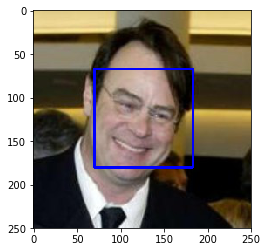

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

I will write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, named `face_detector`, takes a string-valued file path to an image as input:

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assessment of the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance. I will extract the file paths for the first 100 images from each of the datasets and will store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

In [5]:
# Implementation
human_files_faces = 0
dog_files_faces = 0

for file in human_files_short: 
    if face_detector(file): 
        human_files_faces += 1
        
for file in dog_files_short: 
    if face_detector(file): 
        dog_files_faces += 1

print("Faces detected on humans {:.0%}".format(human_files_faces/100))
print("Faces detected on dogs {:.0%}".format(dog_files_faces/100))

Faces detected on humans 98%
Faces detected on dogs 17%


---
<a id='step2'></a>
## Step 2: Detecting Dogs

In this section, I will use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/) - a large and popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

VGG16 expects 224-dim square images as input thus we should resize the images.

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 102402027.23it/s]


In [6]:
# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, I will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Note that we will have to appropriately pre-process tensors for pre-trained models - see the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from torchvision import datasets, models, transforms

In [8]:
# A function to load and transform the image
def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Return prediction using VGG
def VGG16_predict(img_path, showimage = False):
    '''
    Using pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    # Load the image 
    image = image_loader(data_transforms, img_path)
    
    # Show the image  
    if showimage: 
        plt.imshow(np.transpose(image.detach().numpy()[0], (1, 2, 0))) 
    
    image = image.cuda(async=True)
    
    # Return the index of predicted class
    result =  np.argmax(VGG16(image).cpu().detach().numpy())
    
    return result # predicted class index

Let's try this out:

617

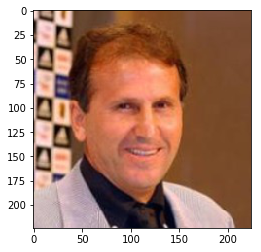

In [9]:
VGG16_predict('/data/lfw/Zico/Zico_0002.jpg', showimage=True)

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), one could notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268 inclusive (categories from `'Chihuahua'` to `'Mexican hairless'`). Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

We will use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    predicted_class = VGG16_predict(img_path)
    if predicted_class in range(151,268): 
        return True 
    else: 
        return False 

### Assessinf the Dog Detector

Let's check the performance of the `dog_detector` function:  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [11]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_dogs = 0 
dogs_dogs = 0

print("Processing human photos")
for i, file in enumerate(human_files_short): 
    if dog_detector(file): 
        human_dogs += 1

print("Processing dog photos")
for i, file in enumerate(dog_files_short): 
    if dog_detector(file): 
        dogs_dogs += 1

Processing human photos
Processing dog photos


In [13]:
print("Dogs detected in human photos: {:.0%}".format(human_dogs/100))
print("Dogs detected on dog photos: {:.0%}".format(dogs_dogs/100))

Dogs detected in human photos: 0%
Dogs detected on dog photos: 90%


This is much better result than what we had with the openCV!

---
<a id='step3'></a>
## Step 3: Creating a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict the breed from images. In this step, I am creating a CNN that classifies dog breeds from scratch.  In Step 4 of this notebook, I am using transfer learning to create a CNN with greatly improved accuracy.

The task of assigning breed to dogs from images is considered exceptionally challenging. To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black. Vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.   

### Specifying Data Loaders for the Dog Dataset

The code cell below includes three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform). 

In [8]:
import os
from torchvision import datasets, transforms
import torch
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Data loaders for training, validation, and test sets

# Small function to return indices for Sampler
def sample_len(data): 
    return list(range(len(train_data)))

# samples per batch to load
batch_size = 20
# number of subprocesses to use for data loading
num_workers = 0

data_dir = '/data/dog_images'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Image Transformation
data_transforms = {
    'train' : transforms.Compose([
    transforms.RandomResizedCrop(32),   
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),

    'valid' : transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),

    'test' : transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

# Reading Dataset
image_datasets = {
    'train' : datasets.ImageFolder(root=train_dir,transform=data_transforms['train']),
    'valid' : datasets.ImageFolder(root=valid_dir,transform=data_transforms['valid']),
    'test' : datasets.ImageFolder(root=test_dir,transform=data_transforms['test'])
}

# Loading Dataset
data_loaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'],batch_size = batch_size,shuffle=True),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'],batch_size = batch_size),
    'test' : torch.utils.data.DataLoader(image_datasets['test'],batch_size = batch_size)    
}

Let's check the images now

Depth 3, H 32, W 32


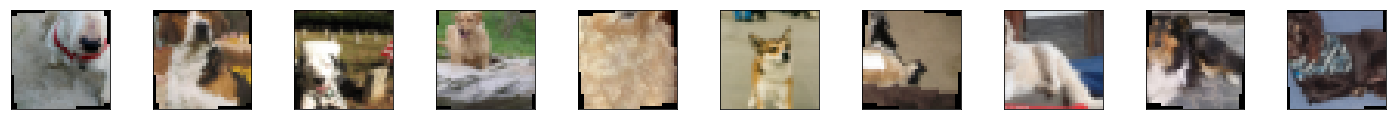

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = dataiter.next()

# Show depth, height, width
_, d, h, w = images.size()
print("Depth {}, H {}, W {}".format(d, h, w))

images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

**Note**:
- To resize the images, I used RandomizedResizeCrop which crops the given PIL Image to the specific size and aspect ratio. I have chosen 200 pixels because the size from 32 to 256 seems to be broadly used looking at papers online ([1](http://cs231n.stanford.edu/reports/2015/pdfs/fcdh_FinalReport.pdf), [2](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Tran_Learning_Spatiotemporal_Features_ICCV_2015_paper.pdf)). This approach did not work, unfortunately (see below in the next section) so I had to change the size to just 32. 
- I added crops and rotations to introduce some variety to data so that NN overfits less. I also introduced normalisation  helps which get data within a specified range and reduces the skewness. Consequently, this helps learn better. 

### Model Architecture

Here I am creating a CNN to classify dog breed. 

In [83]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()  # basic class 
        ## Define layers of a CNN
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 133)
        self.fc2 = nn.Linear(500, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

**Note:**

I started the task with reviewing research on the Internet and stumbled upon a complication that researches rarely build neural nets from scratch but rather implement transfer learning. Therefore I had to run through a series of trials and errors myself before I found a satisfactory solution. 

The examples I found were usually using 200+ width / height images and around 5 convolutional layers. Unfortunately, when I tried similar architectures, I was getting around 1% to 2% accuracy. I was also trying to use BatchNorm2d but unfortunately this did not help.   

Then I completely turned my approach, created transforms to produce small images and first started with just 2 convolutional layers + 1 fully connected, consequently increasing the number to 3 convolutional and 2 fully connected layers. This approach seemed to work because it first bumped up the result to 5%, then to 7%, and finally to 12%. 

### Specifying Loss Function and Optimizer

In the next code cell I am specifying a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html). The loss function was saved as `criterion_scratch`, and the optimizer as `optimizer_scratch`.

In [84]:
import torch.optim as optim

### loss function (categorical cross-entropy)
criterion_scratch = nn.CrossEntropyLoss()

### optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### Training and validating the Model

I will [save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [18]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initializing the tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initializing variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
 
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            # update training loss
            ##train_loss += loss.item()*data.size(0)  
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            ##valid_loss += loss.item()*data.size(0)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            
        # calculate average osses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            )) 
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [16]:
# train the model
model_scratch = train(50, data_loaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 0.000670 	Validation Loss: 0.005304
Validation loss decreased (inf --> 0.005304).  Saving model ...
Epoch: 2 	Training Loss: 0.000657 	Validation Loss: 0.005236
Validation loss decreased (0.005304 --> 0.005236).  Saving model ...
Epoch: 3 	Training Loss: 0.000647 	Validation Loss: 0.005162
Validation loss decreased (0.005236 --> 0.005162).  Saving model ...
Epoch: 4 	Training Loss: 0.000634 	Validation Loss: 0.005169
Epoch: 5 	Training Loss: 0.000626 	Validation Loss: 0.005031
Validation loss decreased (0.005162 --> 0.005031).  Saving model ...
Epoch: 6 	Training Loss: 0.000621 	Validation Loss: 0.005029
Validation loss decreased (0.005031 --> 0.005029).  Saving model ...
Epoch: 7 	Training Loss: 0.000614 	Validation Loss: 0.005007
Validation loss decreased (0.005029 --> 0.005007).  Saving model ...
Epoch: 8 	Training Loss: 0.000607 	Validation Loss: 0.004950
Validation loss decreased (0.005007 --> 0.004950).  Saving model ...
Epoch: 9 	Training Loss: 0.000603 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [78]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [17]:
# call test function    
test(data_loaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.781379


Test Accuracy: 12% (104/836)


This is not a great result, but much better than a random quessing. Transfer Learning will help to improve this. 

---
<a id='step4'></a>
## Step 4: Creating a CNN to Classify Dog Breeds (using Transfer Learning)

I will now use transfer learning to create a CNN that can identify dog breed from images.   

In [85]:
# Have to rewrite loaders because 32 is too small for this transferred model 
 
data_transforms_transfer = {
    'train' : transforms.Compose([
    transforms.RandomResizedCrop(224),   
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),

    'valid' : transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),

    'test' : transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

# Reading Dataset
image_datasets = {
    'train' : datasets.ImageFolder(root=train_dir,transform=data_transforms_transfer['train']),
    'valid' : datasets.ImageFolder(root=valid_dir,transform=data_transforms_transfer['valid']),
    'test' : datasets.ImageFolder(root=test_dir,transform=data_transforms_transfer['test'])
}

# Loading Dataset
loaders_transfer = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'],batch_size = batch_size,shuffle=True),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'],batch_size = batch_size),
    'test' : torch.utils.data.DataLoader(image_datasets['test'],batch_size = batch_size)    
}

### Model Architecture

I will use transfer learning to create a CNN to classify dog breed. I will then save the initialized model as the variable `model_transfer`.

In [86]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.resnet18(pretrained=True)
features_no = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(features_no, 133) # as we have 133 classes of dogs

if use_cuda:
    model_transfer = model_transfer.cuda() 

**Note:**

I decided to use resnet model which is actually referred to in [pytorch tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). I thought that resnet18 (the smallest one) should be enough for the purposes of this exercise which turned out to be correct (after a few iterations). 

Using transfer learning in this case is a reasonable approach due to several reasons:
- A number of models with ones with a massive number ofof convolution layers have been architectured, trained, and improved over the years by many researchers. It wouls be naive to assume that I could develop a better model just from the scratch. 
- The dataset size is really small. We only have 8531 dog images for 133 breeds. Excluding even 20% for validation, this leaves us with roughly 51 image per each breed. This is definitely not enough. I have browsed a number of discussions all suggesting a larger size - for example, see [this one](https://datascience.stackexchange.com/questions/13181/how-many-images-per-class-are-sufficient-for-training-a-cnn).

### Specifying Loss Function and Optimizer

In [87]:
# Loss function and omtimizer
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001)

### Training and Validating the Model

I will train and validate the model in the code cell below.

In [34]:
# train the model
n_epochs = 20

model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, 
                       criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch: 1 	Training Loss: 0.000367 	Validation Loss: 0.002519
Validation loss decreased (inf --> 0.002519).  Saving model ...
Epoch: 2 	Training Loss: 0.000349 	Validation Loss: 0.002404
Validation loss decreased (0.002519 --> 0.002404).  Saving model ...
Epoch: 3 	Training Loss: 0.000334 	Validation Loss: 0.002347
Validation loss decreased (0.002404 --> 0.002347).  Saving model ...
Epoch: 4 	Training Loss: 0.000321 	Validation Loss: 0.002267
Validation loss decreased (0.002347 --> 0.002267).  Saving model ...
Epoch: 5 	Training Loss: 0.000308 	Validation Loss: 0.002079
Validation loss decreased (0.002267 --> 0.002079).  Saving model ...
Epoch: 6 	Training Loss: 0.000296 	Validation Loss: 0.002004
Validation loss decreased (0.002079 --> 0.002004).  Saving model ...
Epoch: 7 	Training Loss: 0.000288 	Validation Loss: 0.002033
Epoch: 8 	Training Loss: 0.000275 	Validation Loss: 0.001896
Validation loss decreased (0.002004 --> 0.001896).  Saving model ...
Epoch: 9 	Training Loss: 0.000265 

In [88]:
# load the model that got the best validation accuracy  
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Test the Model

I will try out the model on the test dataset of dog images: 

In [89]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.237437


Test Accuracy: 69% (582/836)


Much better!

### Predict Dog Breed with the Model

Now I will write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [90]:
class_names = image_datasets['train'].classes

In [91]:
from torch.autograd import Variable

def predict_breed(image_path):
    
    image = Image.open(image_path)

    # Transformations for the image consistent with used previously
    transformation = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    image_tensor = transformation(image).float()

    # Add an extra batch dimension 
    image_tensor = image_tensor.unsqueeze_(0)
    
    if use_cuda: 
        image_tensor = image_tensor.cuda()

    # Turn the input into a Variable
    input = Variable(image_tensor)

    # Return the top predictions and confidence scores
    output = model_transfer(input)
    softmax = nn.Softmax(dim=1)
    preds = softmax(output)
    top_preds = torch.topk(preds, 3)
    pred_breeds = [class_names[i] for i in top_preds[1][0]]
    confidence = top_preds[0][0]
    
    return pred_breeds, confidence

In [92]:
test_img_path = '/data/dog_images/test/059.Doberman_pinscher/Doberman_pinscher_04169.jpg'
predict_breed(test_img_path)

(['059.Doberman_pinscher',
  '070.German_pinscher',
  '025.Black_and_tan_coonhound'],
 tensor([ 0.3823,  0.1605,  0.1539], device='cuda:0'))

All right, this seems to be working fine. We can check this on a batch. 

In [93]:
test_img_paths = sorted(glob('/data/dog_images/test/*/*'))
np.random.shuffle(test_img_paths)
test_img_paths[0:3]

['/data/dog_images/test/002.Afghan_hound/Afghan_hound_00143.jpg',
 '/data/dog_images/test/121.Plott/Plott_07795.jpg',
 '/data/dog_images/test/115.Papillon/Papillon_07451.jpg']

In [102]:
import matplotlib.image as mpimg
import random

def dog_breed(img_paths):

    for img_path in img_paths:   
        
        # Display an image
        _, ax = plt.subplots()
        img = mpimg.imread(img_path)
        _ = ax.imshow(img)
        plt.axis('off')
        plt.show()

        # Extract breed from the path
        actual_breed = img_path.split('/')[4].split('.')[1]
        print("Actual Breed: {}\n".format(actual_breed))
        
        # Display breeds and scores
        breeds, confidence = predict_breed(img_path)
        predictions = ""
        for breed, conf in zip(breeds, confidence):
            if conf > 0.05: # take 5% as a threshold 
                predictions = "{}{} {:.0%}\n".format(predictions, breed, conf) 
        print("Predicted Breed:\n{}".format(predictions))


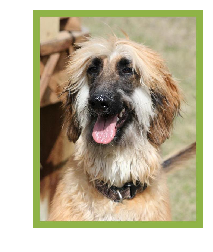

Actual Breed: Afghan_hound

Predicted Breed:
002.Afghan_hound 87%



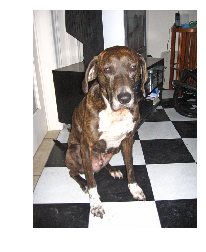

Actual Breed: Plott

Predicted Breed:
121.Plott 17%
081.Greyhound 13%
008.American_staffordshire_terrier 9%



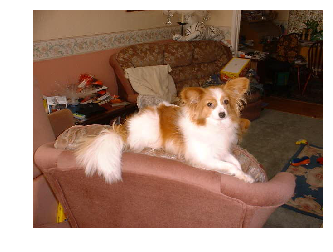

Actual Breed: Papillon

Predicted Breed:
115.Papillon 77%
091.Japanese_chin 7%



In [103]:
dog_breed(test_img_paths[0:3])

All right, looks good indeed. 

---
<a id='step5'></a>
## Step 5: Writing an algorithm

I will write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [104]:
def run_app(img_path):
    
    breeds, confidence = predict_breed(img_path)
    
    _, ax = plt.subplots()
    
    if confidence[0] > 0.3: # should be confident in predicting that this is a dog
        print("Hello doggie")
        
        # Display the image 
        img = mpimg.imread(img_path)
        _ = ax.imshow(img)
        plt.axis('off')
        plt.show()
        
        # Display breeds and scores 
        predictions = ""
        for breed, conf in zip(breeds, confidence):
            if conf > 0.1: # take 10% as a threshold 
                predictions = "{}{} {:.0%}\n".format(predictions, breed, conf) 
        print("Predicted Breed:\n{}".format(predictions))  
           
        # Display similar breed images
        fig = plt.figure(figsize=(10,5)) 
        for i, breed in enumerate(breeds):
            subdir = '/'.join(['/data/dog_images/valid', breed])
            file = random.choice(os.listdir(subdir))
            path = '/'.join([subdir, file])
            img = mpimg.imread(path)
            ax = fig.add_subplot(1,3,i+1)
            ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
            plt.title(breed)
            plt.axis('off')
        plt.show() 
    
    elif face_detector(img_path):
        print("Hello human")
        
        # Display the image 
        img = mpimg.imread(img_path)
        _ = ax.imshow(img)        
        plt.axis('off')
        plt.show()
        
        # Display similar breeds
        resemblance = ""
        for breed, conf in zip(breeds, confidence):
            resemblance = "{}{} {:.0%}\n".format(resemblance, breed, conf)
        print("Alike dog breeds:\n{}".format(resemblance))   
        
        # display sample of matching breed images
        fig = plt.figure(figsize=(16,4)) 
        for i, breed in enumerate(breeds):
            subdir = '/'.join(['/data/dog_images/valid', breed])
            file = random.choice(os.listdir(subdir))
            path = '/'.join([subdir, file])
            img = mpimg.imread(path)
            ax = fig.add_subplot(1,3,i+1)
            ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
            plt.title(breed)
            plt.axis('off')
        plt.show()
        
    else:
        print("Cannot determine what this is")
        img = mpimg.imread(img_path)
        _ = ax.imshow(img)        
        plt.axis('off')
        plt.show()     
    

Let's try it out:

Hello doggie


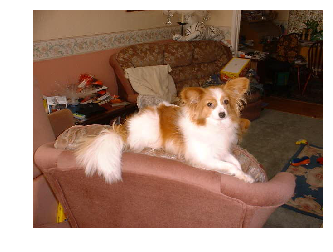

Predicted Breed:
115.Papillon 35%



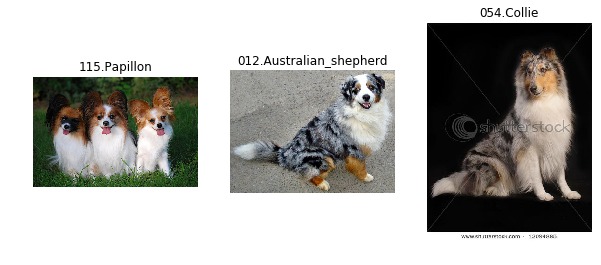

Hello doggie


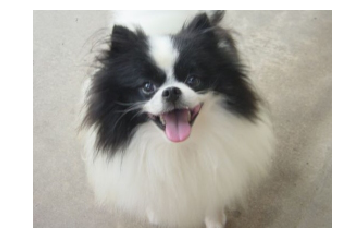

Predicted Breed:
115.Papillon 49%
091.Japanese_chin 33%



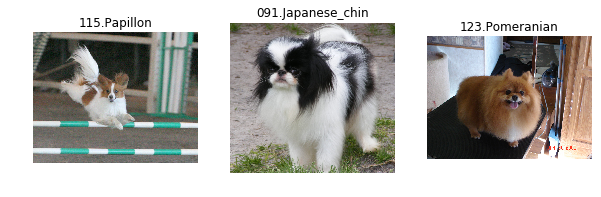

In [108]:
for i in range(0,2): 
    run_app(test_img_paths[random.randint(0, 10)]) 

And on people: 

In [109]:
test_img_paths_humans = sorted(glob('/data/lfw/*/*'))
np.random.shuffle(test_img_paths_humans)
test_img_paths_humans[0:3]

['/data/lfw/Beatrice_Dalle/Beatrice_Dalle_0001.jpg',
 '/data/lfw/Paul_Sarbanes/Paul_Sarbanes_0003.jpg',
 '/data/lfw/Fabiola_Zuluaga/Fabiola_Zuluaga_0001.jpg']

Hello human


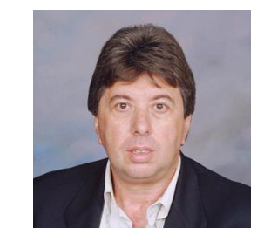

Alike dog breeds:
001.Affenpinscher 6%
131.Wirehaired_pointing_griffon 5%
133.Yorkshire_terrier 3%



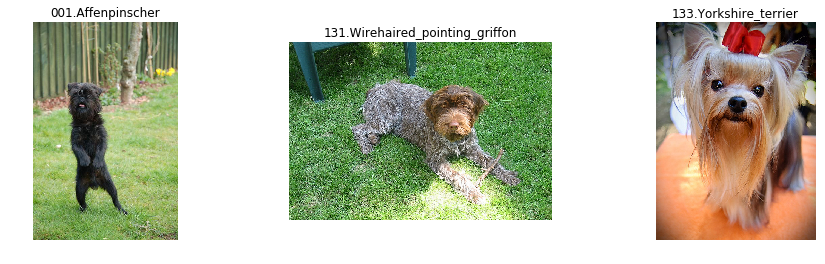

Hello human


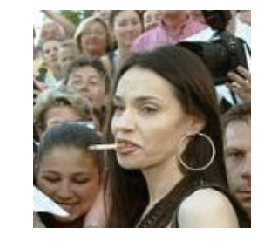

Alike dog breeds:
008.American_staffordshire_terrier 9%
049.Chinese_crested 5%
069.French_bulldog 3%



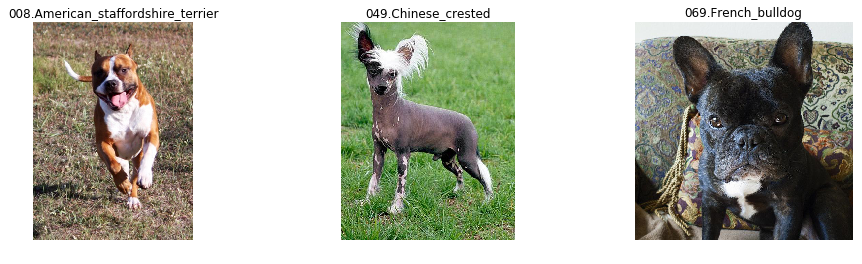

In [110]:
for i in range(0,2): 
    run_app(test_img_paths_humans[random.randint(0, 10)]) 

**Note:** The predictions for dogs seem to be good. However, for the photos of people the output is not that great because it gives similar dog breeds with very low confidence. I would suggest that the improvements could be the following: 

- Use style transfer, apply 'dog' style to a human photo and then find similar dog breeds instead of just using human photos. 
- Our dataset for training and testing is very small for a task of creating a neural net. Even for transfer learning, we should use a larger dataset. 
- Instead of just using resnet18, various architectures could be tried to increase accuracy and decrease prediction time. 